In [6]:
import numpy as np
np.random.seed(5)

import functions_class as fx
import classx as cl
import log_reg_functions as lrf
import loaddata as ld


import time
import matplotlib.pyplot as plt
import pandas as pd
import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import log_loss, f1_score

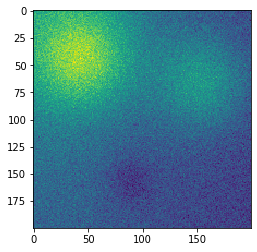

In [7]:
n=200

x = np.linspace(0,1,n)
y = x

x_mesh, y_mesh  = np.meshgrid(x,y)
noise_level     = 0.1
frank           = fx.FrankeFunction(x_mesh, y_mesh, noise_level)


plt.imshow(frank)
plt.show()

frank=frank.ravel()

In [4]:
class ANN():
    def __init__(self, lmb=0, bias=0, eta=0.0001):
        self.lmb=lmb
        self.bias = bias
        self.layers=dict()
        self.n_layers=int()
        
        self.pred=dict()
        self.act=dict()
        self.eta=eta
        
    def add_layers(self, n_neurons=[20,5], n_features=[20,5], n_layers=2):
        self.n_layers=n_layers
        for i in range(n_layers):
            layer_weights = np.random.randn(n_features[i], n_neurons[i])
            self.layers['w'+str(i)] = layer_weights
            layer_bias = np.zeros(n_neurons[i]) + self.bias
            self.layers['b'+str(i)] = layer_bias
    
    def feed(self, design, activation=[lrf.sigmoid,lrf.sigmoid, lrf.sigmoid]):
        
        for i in range(self.n_layers):
            
            if i==0:
                self.pred[str(i)] = np.matmul(design, self.layers['w'+str(i)]) + self.layers['b'+str(i)]
                self.act[str(i)] = activation[i](self.pred[str(i)])
            else:
                self.pred[str(i)] = np.matmul(self.act[str(i-1)], self.layers['w'+str(i)]) + self.layers['b'+str(i)]                
                self.act[str(i)] = activation[i](self.pred[str(i)])
  
    def back(self, design, data, derivative=[lrf.sigmoid_deriv, lrf.sigmoid_deriv, lrf.sigmoid_deriv]):
        
        for i in np.arange(self.n_layers-1,0,-1):
            if i==self.n_layers-1:
                error = self.act[str(i)] - data
            else:
                error = np.matmul(error, self.layers['w'+str(i+1)].T) * derivative[i](self.act[str(i)])
            if i == 0:
                gradients_weights = np.matmul(design.T, error)
                gradients_bias = np.sum(error, axis=0)
            else:
                gradients_weights = np.matmul(self.act[str(i-1)].T, error)
                gradients_bias = np.sum(error, axis=0)
            
            
            self.layers['w'+str(i)] -= self.eta * gradients_weights
            self.layers['b'+str(i)] -= self.eta * gradients_bias
   
    def feed_out(self, design, activation=[lrf.sigmoid,lrf.sigmoid, lrf.sigmoid]):
        
        for i in range(self.n_layers):
            
            if i==0:
                self.pred[str(i)] = np.matmul(design, self.layers['w'+str(i)]) + self.layers['b'+str(i)]
                self.act[str(i)] = activation[i](self.pred[str(i)])
            else:
                self.pred[str(i)] = np.matmul(self.act[str(i-1)], self.layers['w'+str(i)]) + self.layers['b'+str(i)]                
                self.act[str(i)] = activation[i](self.pred[str(i)])
        return self.act
    
    def train(self, epochs, bath_size, x, y, activation, derivative):
        tmp=int(len(y)/batch_size)
        Niter = min(200,tmp)
        indexes = np.arange(len(y))
        for i in range(epochs):
            for j in range(Niter):
                datapoints = np.random.choice(indexes, size=batch_size, replace=False)
                batch_x = x[datapoints,:]
                batch_y = y[datapoints]
                
                self.feed(x, activation)
                self.back(x,y, derivative)
            pred = self.feed_out(x, activation)[str(self.n_layers-1)]
            cost = fx.MSE(pred,y.T)
            print('Epoch', i, 'loss', cost )
        

In [ ]:
neural_net = ANN(lmb=0.3, bias=0.24, eta=0.00005)            
neural_net.add_layers(n_features=[21,50,50,20], n_neurons = [50,50,20,1] , n_layers=4)

design=fx.DesignDesign(x,y,5)

activation = [lrf.relu, lrf.relu, lrf.relu, lrf.nooutact]
derivative = [lrf.relu_deriv, lrf.relu_deriv, lrf.relu_deriv, lrf.nooutact]

start = time.time()


epochs=10
batch_size=100
neural_net.train(epochs, batch_size, design,frank,activation,derivative)

end = time.time()
print(end - start)

In [ ]:
as